C:\Users\cheth\AppData\Local\Temp\ipykernel_6228\2058280983.py:64: RuntimeWarning: divide by zero encountered in divide
  evi = 2.5 * ((b8 - b4) / (b8 + 6 * b4 - 7.5 * b2 + 1))


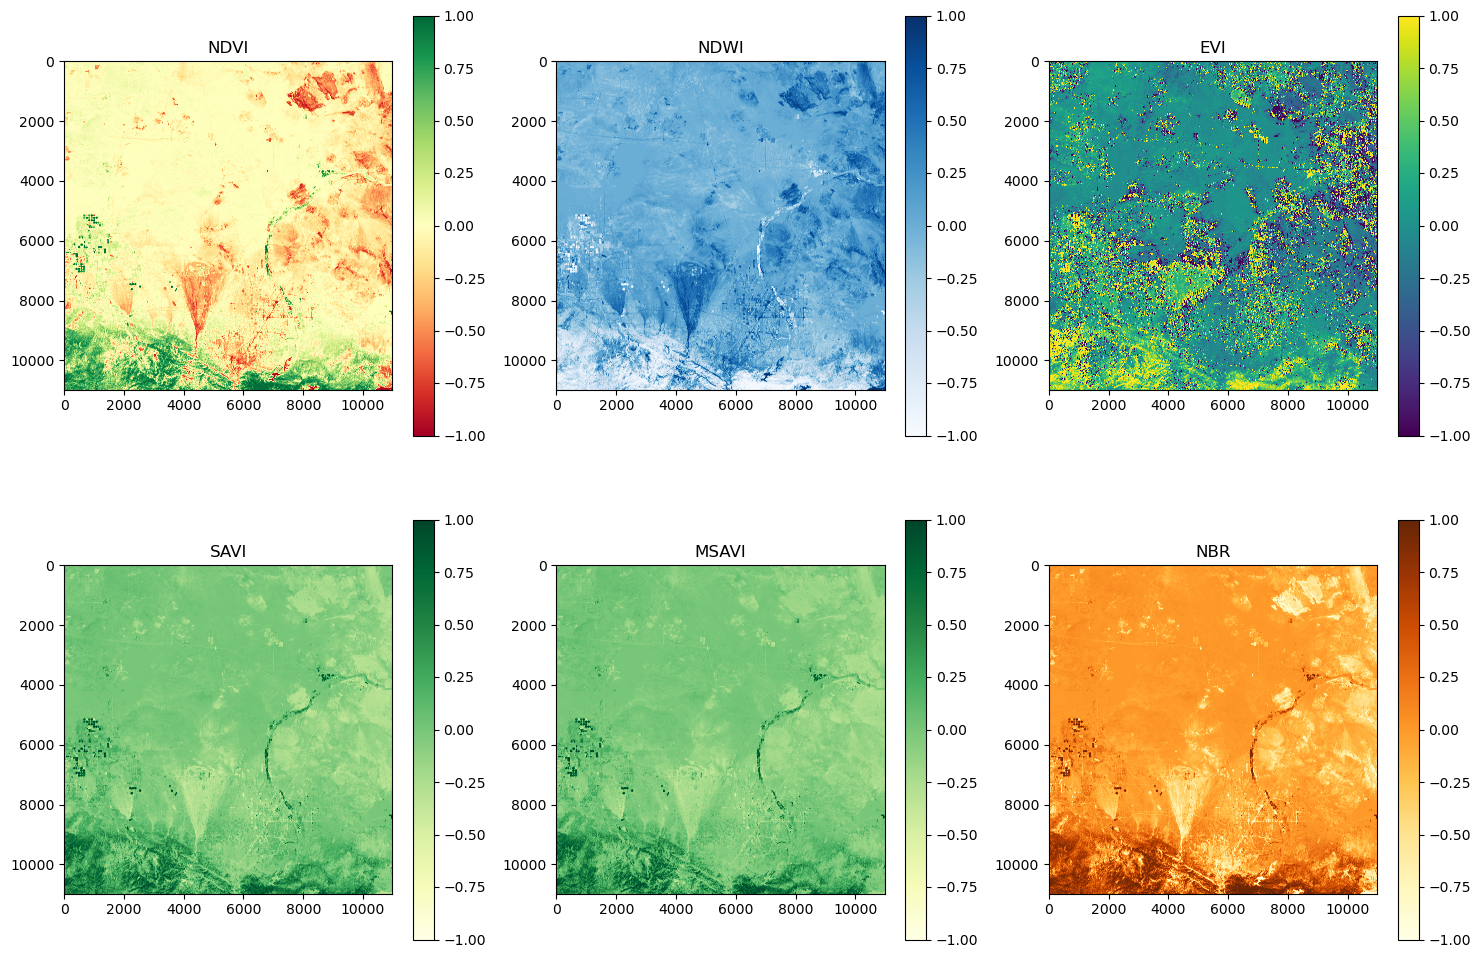

In [1]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure, img_as_float
from scipy.ndimage import gaussian_filter

# Define file paths for the satellite images
image_files = {
    'B02': './T11SMU_20240701T182919_B02_10m.jp2',
    'B03': './T11SMU_20240701T182919_B03_10m.jp2',
    'B04': './T11SMU_20240701T182919_B04_10m.jp2',
    'B08': './T11SMU_20240701T182919_B08_10m.jp2',
}

# Load the bands
bands = {}
for band, path in image_files.items():
    with rasterio.open(path) as src:
        bands[band] = src.read(1).astype('float32')  # Ensure the data type is float32 for calculation

# Normalization function
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())

# Apply normalization to all bands
for band in bands:
    bands[band] = normalize_band(bands[band])

# Noise reduction using Gaussian filter
def reduce_noise(band, sigma=1):
    return gaussian_filter(band, sigma=sigma)

# Apply noise reduction to all bands
for band in bands:
    bands[band] = reduce_noise(bands[band])

# Image enhancement using histogram equalization
def enhance_contrast(band):
    band = img_as_float(band)
    return exposure.equalize_hist(band)

# Apply contrast enhancement to all bands
for band in bands:
    bands[band] = enhance_contrast(bands[band])

# Calculate NDVI
def calculate_ndvi(b4, b8):
    ndvi = (b8 - b4) / (b8 + b4)
    ndvi[np.isnan(ndvi)] = 0  # Handle division by zero
    return ndvi

ndvi = calculate_ndvi(bands['B04'], bands['B08'])

# Calculate NDWI
def calculate_ndwi(b3, b8):
    ndwi = (b3 - b8) / (b3 + b8)
    ndwi[np.isnan(ndwi)] = 0  # Handle division by zero
    return ndwi

ndwi = calculate_ndwi(bands['B03'], bands['B08'])

# Calculate EVI (Enhanced Vegetation Index)
def calculate_evi(b2, b4, b8):
    evi = 2.5 * ((b8 - b4) / (b8 + 6 * b4 - 7.5 * b2 + 1))
    evi[np.isnan(evi)] = 0  # Handle division by zero
    return evi

evi = calculate_evi(bands['B02'], bands['B04'], bands['B08'])

# Calculate SAVI (Soil Adjusted Vegetation Index)
def calculate_savi(b4, b8, L=0.5):
    savi = ((b8 - b4) / (b8 + b4 + L)) * (1 + L)
    savi[np.isnan(savi)] = 0  # Handle division by zero
    return savi

savi = calculate_savi(bands['B04'], bands['B08'])

# Calculate MSAVI (Modified Soil Adjusted Vegetation Index)
def calculate_msavi(b4, b8):
    msavi = (2 * b8 + 1 - np.sqrt((2 * b8 + 1) ** 2 - 8 * (b8 - b4))) / 2
    msavi[np.isnan(msavi)] = 0  # Handle division by zero
    return msavi

msavi = calculate_msavi(bands['B04'], bands['B08'])

# Calculate NBR (Normalized Burn Ratio)
def calculate_nbr(b4, b8):
    nbr = (b8 - b4) / (b8 + b4)
    nbr[np.isnan(nbr)] = 0  # Handle division by zero
    return nbr

nbr = calculate_nbr(bands['B04'], bands['B08'])

# Display all calculated features
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('NDVI')

plt.subplot(2, 3, 2)
plt.imshow(ndwi, cmap='Blues', vmin=-1, vmax=1)
plt.colorbar()
plt.title('NDWI')

plt.subplot(2, 3, 3)
plt.imshow(evi, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar()
plt.title('EVI')

plt.subplot(2, 3, 4)
plt.imshow(savi, cmap='YlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('SAVI')

plt.subplot(2, 3, 5)
plt.imshow(msavi, cmap='YlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('MSAVI')

plt.subplot(2, 3, 6)
plt.imshow(nbr, cmap='YlOrBr', vmin=-1, vmax=1)
plt.colorbar()
plt.title('NBR')

plt.show()


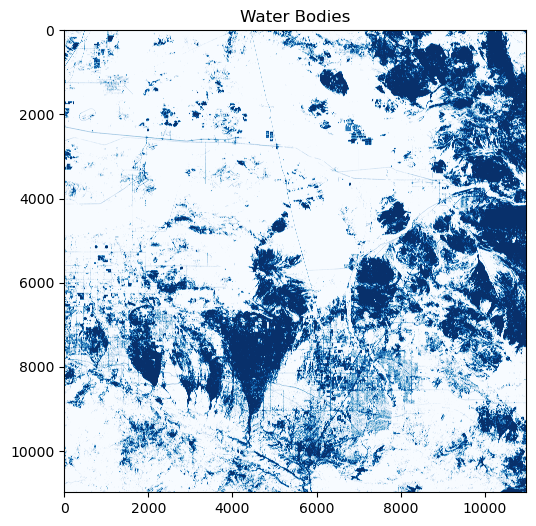

In [2]:
# Threshold NDWI to identify water bodies
water_bodies = ndwi > 0.1

plt.figure(figsize=(6, 6))
plt.imshow(water_bodies, cmap='Blues')
plt.title('Water Bodies')
plt.show()


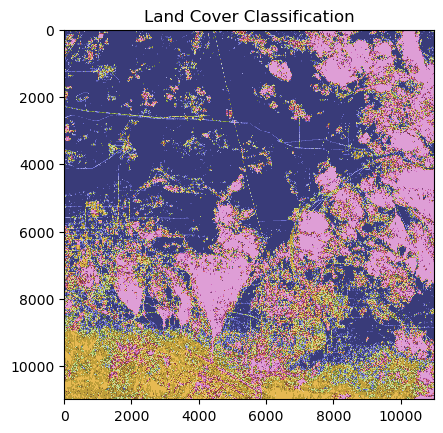

In [3]:
def classify_land_cover(ndvi, ndwi):
    land_cover = np.zeros_like(ndvi)
    land_cover[ndvi > 0.3] = 1  # Vegetation
    land_cover[(ndwi > 0.1) & (ndvi <= 0.3)] = 2  # Water
    return land_cover

land_cover = classify_land_cover(ndvi, ndwi)

plt.imshow(land_cover, cmap='tab20b')
plt.title('Land Cover Classification')
plt.show()


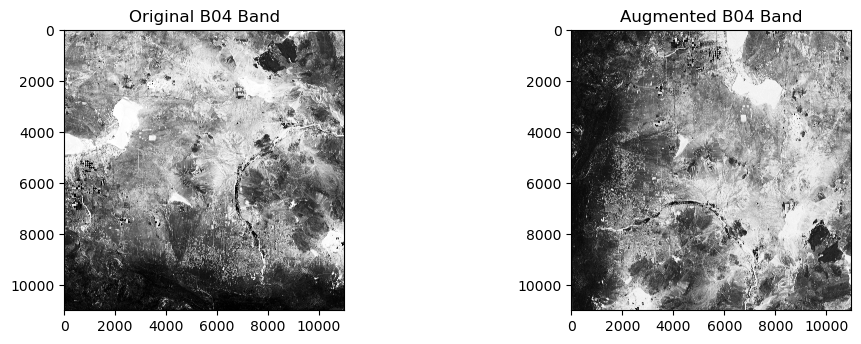

In [4]:
import random
from PIL import Image, ImageOps, ImageEnhance

# Data Augmentation
def augment_image(image_array):
    image = Image.fromarray((image_array * 255).astype('uint8'))  # Convert to uint8 for PIL processing
    
    # Random Rotation
    angle = random.choice([0, 90, 180, 270])
    image = image.rotate(angle)
    
    # Random Flipping
    if random.choice([True, False]):
        image = ImageOps.flip(image)
    if random.choice([True, False]):
        image = ImageOps.mirror(image)
    
    # Random Scaling
    scale_factor = random.uniform(0.8, 1.2)
    new_size = tuple([int(dim * scale_factor) for dim in image.size])
    image = image.resize(new_size, Image.LANCZOS)
    
    # Center Crop to original size
    image = ImageOps.fit(image, (image_array.shape[1], image_array.shape[0]), method=Image.LANCZOS)
    
    # Add random noise
    noise = np.random.normal(0, 0.1, (image_array.shape[0], image_array.shape[1])).astype('float32')
    image_array_noisy = np.array(image).astype('float32') / 255 + noise
    image_array_noisy = np.clip(image_array_noisy, 0, 1)
    
    return image_array_noisy

# Apply augmentations to each band
augmented_images = {band: augment_image(image) for band, image in bands.items()}

# Display original and augmented images for comparison
plt.figure(figsize=(12, 8))

# Original image example (Band B04)
plt.subplot(2, 2, 1)
plt.imshow(bands['B04'], cmap='gray')
plt.title('Original B04 Band')

# Augmented image example (Band B04)
plt.subplot(2, 2, 2)
plt.imshow(augmented_images['B04'], cmap='gray')
plt.title('Augmented B04 Band')

plt.show()

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('./LOS_ANGELES.csv')

# Keep only the relevant columns including the date column
columns_to_keep = ['DATE', 'PRCP', 'TAVG', 'TMAX', 'TMIN']
data = data[columns_to_keep]

# Convert the date column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'], format='%d/%m/%Y')

# Filter the data from January 1, 2004 onwards
data = data[data['DATE'] >= '2004-01-01']

# Handle missing values by filling them with the mean of each column (excluding the date column)
data[columns_to_keep[1:]] = data[columns_to_keep[1:]].fillna(data[columns_to_keep[1:]].mean())

data['TAVG'] = (data['TMAX'] + data['TMIN']) / 2

# Normalize the data (excluding the date column)
scaler = StandardScaler()
data[columns_to_keep[1:]] = scaler.fit_transform(data[columns_to_keep[1:]])

# Display the normalized DataFrame
data.head()


,DATE,PRCP,TAVG,TMAX,TMIN
0,2004-01-01,-0.178269,-1.870965,-1.369544,-2.197055
1,2004-01-02,1.956226,-1.936382,-2.464053,-0.967962
2,2004-01-03,-0.178269,-2.132632,-1.916799,-2.060489
3,2004-01-04,-0.178269,-2.198048,-1.588446,-2.606752
4,2004-01-05,-0.178269,-1.609298,-1.041192,-2.060489


C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

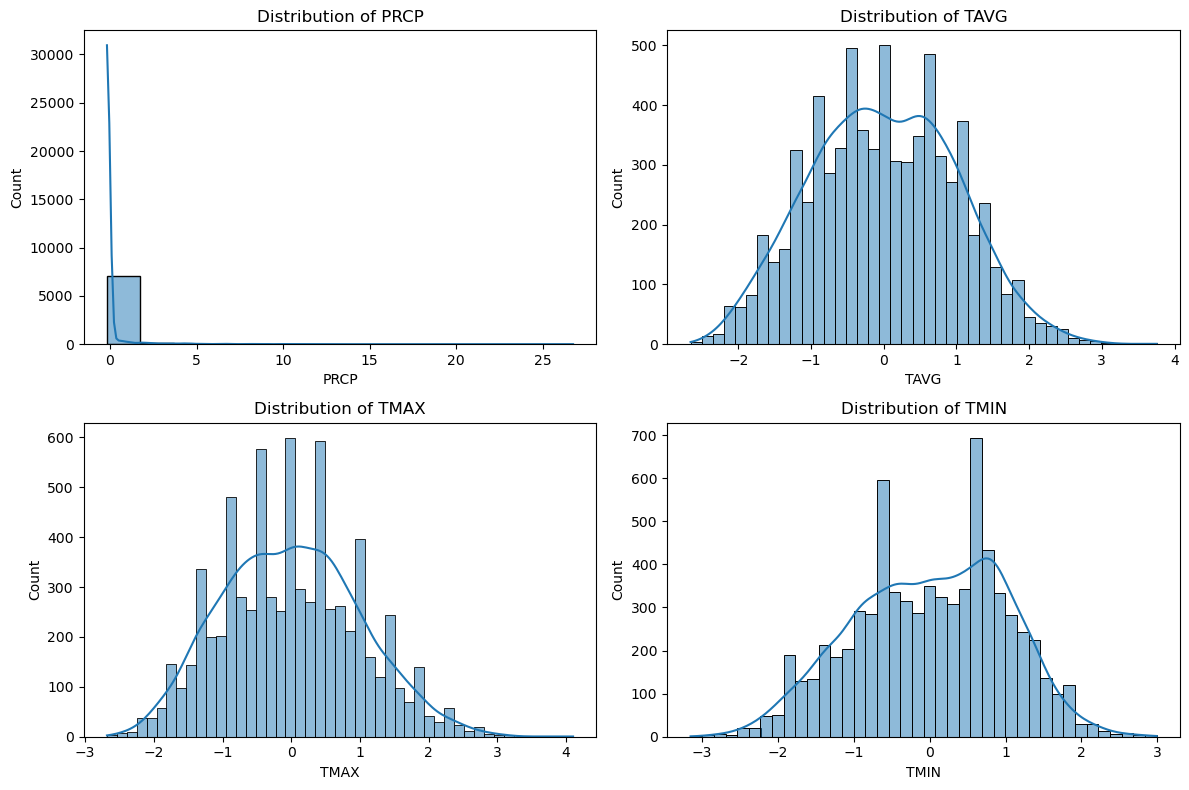

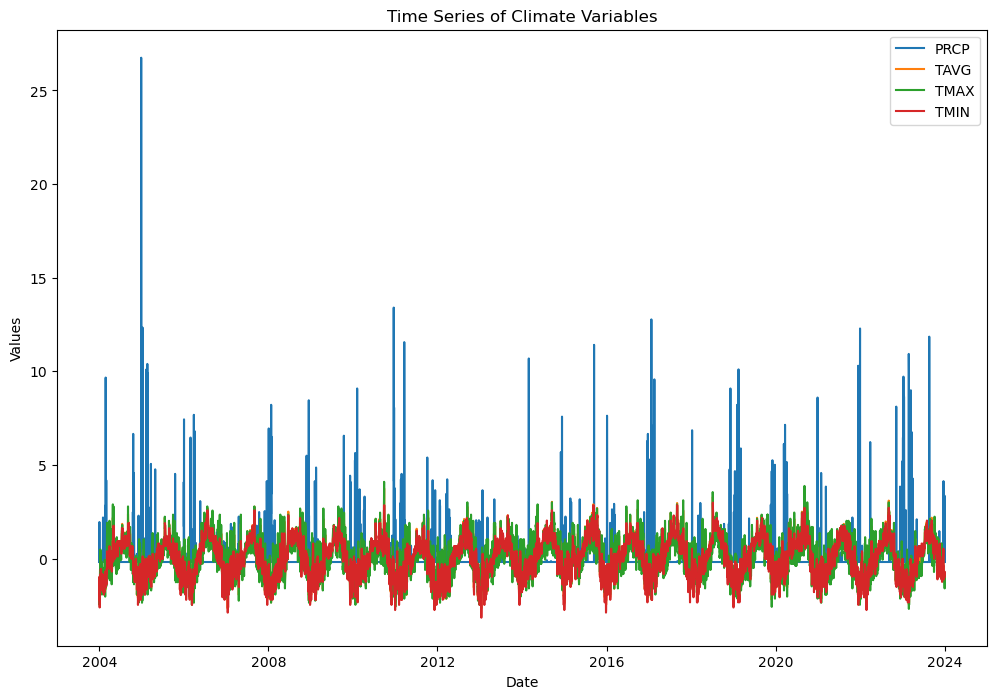

C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

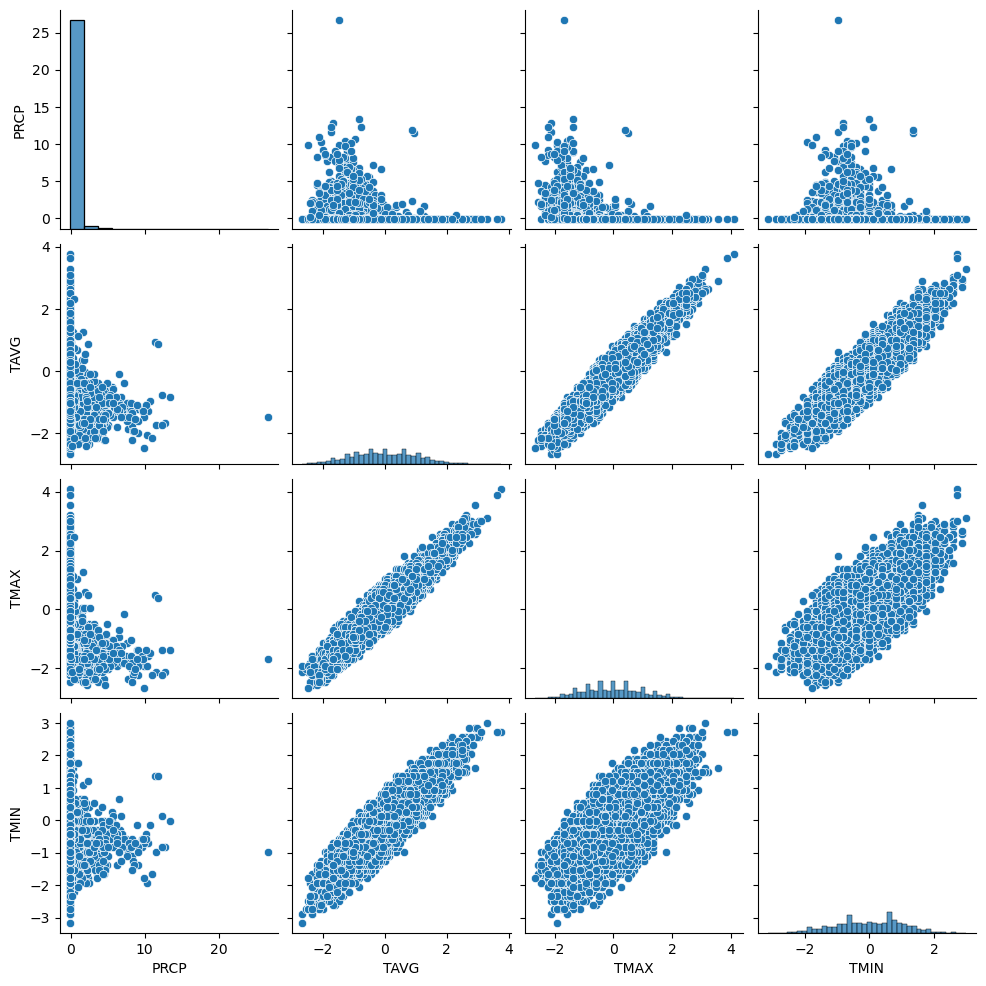

          PRCP      TAVG      TMAX      TMIN
PRCP  1.000000 -0.215064 -0.264068 -0.119487
TAVG -0.215064  1.000000  0.943455  0.910448
TMAX -0.264068  0.943455  1.000000  0.721850
TMIN -0.119487  0.910448  0.721850  1.000000


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distributions of the variables
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_to_keep[1:], 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Plot the time series of the variables
plt.figure(figsize=(12, 8))
for column in columns_to_keep[1:]:
    plt.plot(data['DATE'], data[column], label=column)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Climate Variables')
plt.legend()
plt.show()

# Pairplot to visualize relationships
sns.pairplot(data[columns_to_keep[1:]])
plt.show()

# Correlation matrix
correlation_matrix = data[columns_to_keep[1:]].corr()

# Print the correlation matrix
print(correlation_matrix)


In [30]:
import numpy as np

# Create sequences of data
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Prepare the data for time series analysis
seq_length = 30  # Sequence length of 30 days
data_values = data[columns_to_keep[1:]].values
X, y = create_sequences(data_values, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')


Training data shape: (5820, 30, 4), Training labels shape: (5820, 4)
Testing data shape: (1456, 30, 4), Testing labels shape: (1456, 4)


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(4)  # Output layer with 4 neurons for PRCP, TAVG, TMAX, TMIN
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Display the model architecture
model.summary()


C:\Users\cheth\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,204 (43.77 KB)

 Trainable params: 11,204 (43.77 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.7548 - val_loss: 0.4057
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.4694 - val_loss: 0.3642
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.3032 - val_loss: 0.3615
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2992 - val_loss: 0.3597
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.3111 - val_loss: 0.3604
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.2636 - val_loss: 0.3644
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.3523 - val_loss: 0.3679
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3124 - val_loss: 0.3653
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.3411 - val_loss: 0.3640
Epoch 10/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2859 - val_loss: 0.3723
Epoch 11/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3028 - val_loss: 0.3602
Epoch 12/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3377
Test Loss: 0.43084263801574707


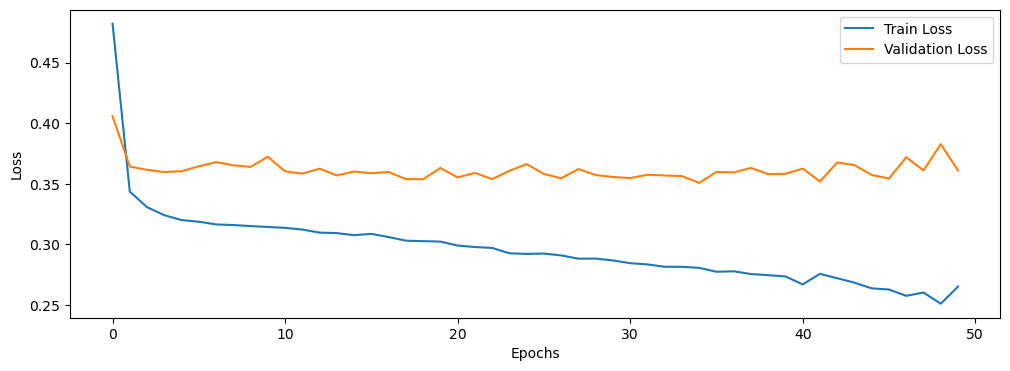

In [36]:
import matplotlib.pyplot as plt

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


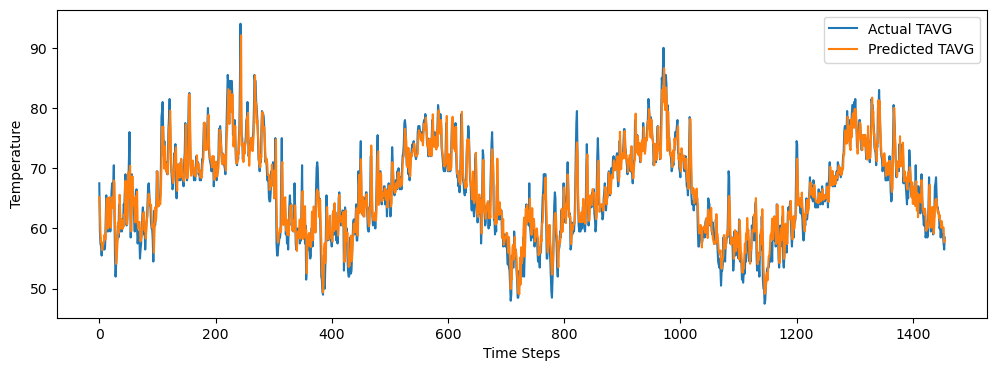

In [38]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to get the original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot the actual vs predicted values for TAVG (example)
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv[:, 1], label='Actual TAVG')
plt.plot(y_pred_inv[:, 1], label='Predicted TAVG')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()


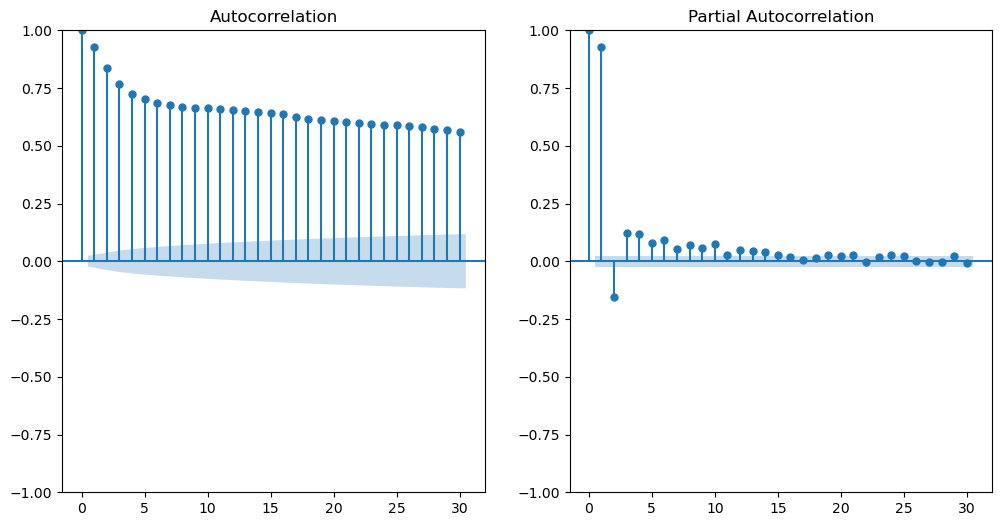

In [41]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the TAVG series
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data['TAVG'], ax=plt.gca(), lags=30)
plt.subplot(122)
plot_pacf(data['TAVG'], ax=plt.gca(), lags=30)
plt.show()


In [43]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(data['TAVG'], order=(1, 0, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   TAVG   No. Observations:                 7306
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3147.981
Date:                Mon, 15 Jul 2024   AIC                           6303.962
Time:                        14:41:14   BIC                           6331.547
Sample:                             0   HQIC                          6313.447
                               - 7306                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0046      0.052     -0.090      0.928      -0.106       0.097
ar.L1          0.8989      0.005    167.195      0.000       0.888       0.909
ma.L1          0.1951      0.011     17.574      0.0

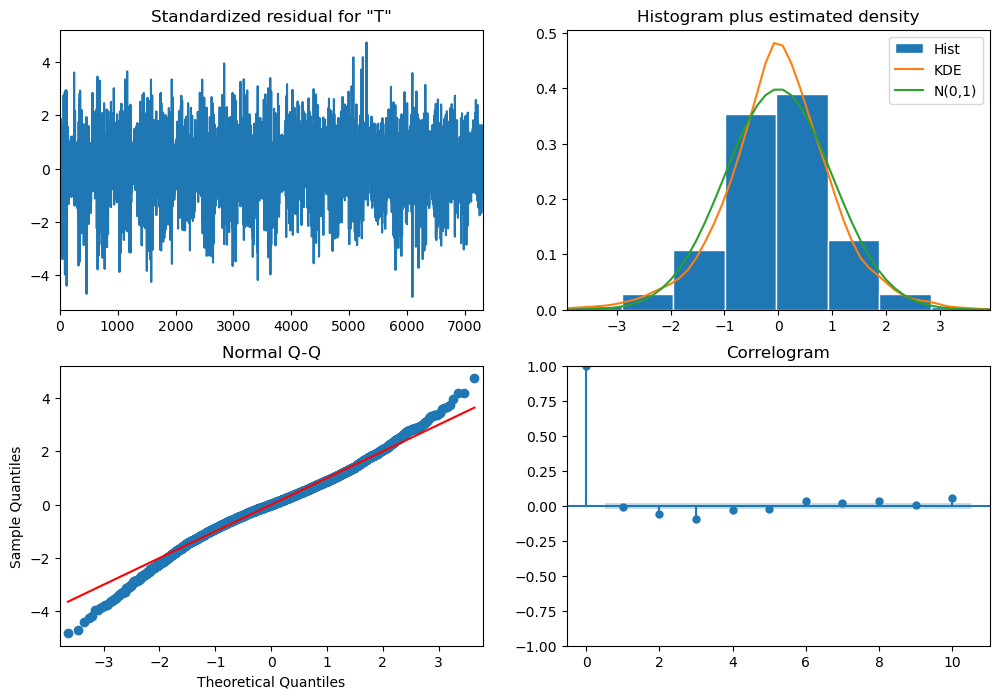

In [45]:
# Plot diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()


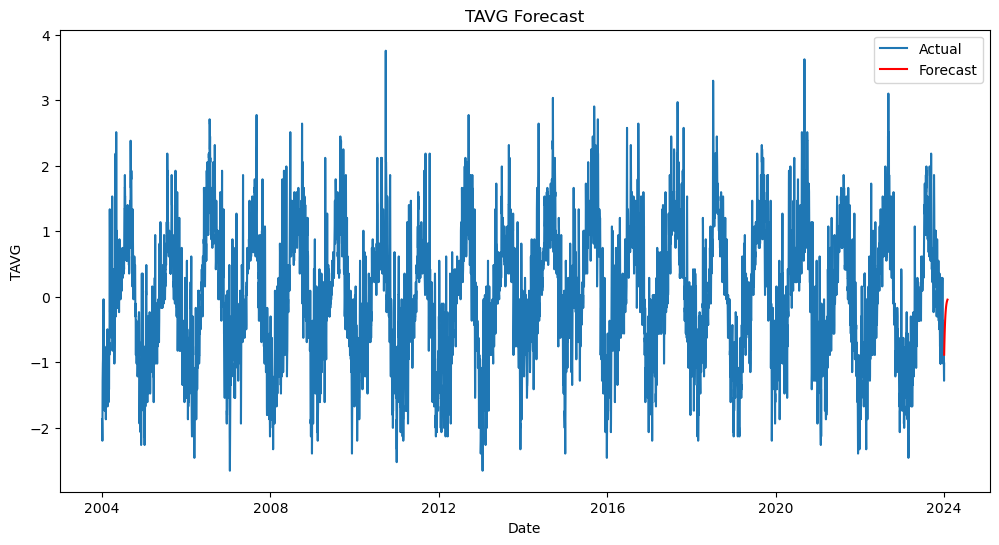

In [47]:
# Forecast
forecast_steps = 30  # Number of days to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['DATE'], data['TAVG'], label='Actual')
forecast_dates = pd.date_range(start=data['DATE'].iloc[-1], periods=forecast_steps, freq='D')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('TAVG')
plt.title('TAVG Forecast')
plt.legend()
plt.show()


In [50]:
from sklearn.model_selection import train_test_split

# Split data into features and target
X = data[['PRCP', 'TMAX', 'TMIN']]
y = data['TAVG']  # Example target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [52]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_mae = mean_absolute_error(y_test, gb_predictions)

print(f'Random Forest - MSE: {rf_mse}, MAE: {rf_mae}')
print(f'Gradient Boosting - MSE: {gb_mse}, MAE: {gb_mae}')


Random Forest - MSE: 0.00011553780708141032, MAE: 0.002276160040695651
Gradient Boosting - MSE: 0.0007579346337447275, MAE: 0.020736999454683987


In [54]:
from sklearn.svm import SVR

# Support Vector Regressor
svm_model = SVR()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

# Evaluate the model
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_mae = mean_absolute_error(y_test, svm_predictions)

print(f'SVM - MSE: {svm_mse}, MAE: {svm_mae}')


SVM - MSE: 0.0019047879144100481, MAE: 0.033595289049017936


In [56]:
from sklearn.model_selection import GridSearchCV

# Example for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
best_rf_predictions = best_rf_model.predict(X_test)
best_rf_mse = mean_squared_error(y_test, best_rf_predictions)
best_rf_mae = mean_absolute_error(y_test, best_rf_predictions)

print(f'Best Random Forest - MSE: {best_rf_mse}, MAE: {best_rf_mae}')


C:\Users\cheth\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\cheth\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\cheth\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestR

Best Random Forest - MSE: 0.00010865317632351463, MAE: 0.002126041760048837


In [60]:
import numpy as np
import os
import rasterio
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Function to create image patches
def create_image_patches(stacked_images, patch_size=128):
    patches = []
    for i in range(0, stacked_images.shape[0] - patch_size + 1, patch_size):
        for j in range(0, stacked_images.shape[1] - patch_size + 1, patch_size):
            patch = stacked_images[i:i + patch_size, j:j + patch_size]
            patches.append(patch)
    return np.array(patches)

# Load the bands and stack them to create multi-band images
def load_and_stack_bands(image_files):
    bands = []
    for key in image_files:
        with rasterio.open(image_files[key]) as src:
            band = src.read(1).astype('float32')
            bands.append(band)
    return np.stack(bands, axis=-1)

# Define the file paths for the satellite images
image_files = {
    'B02': './T11SMU_20240701T182919_B02_10m.jp2',
    'B03': './T11SMU_20240701T182919_B03_10m.jp2',
    'B04': './T11SMU_20240701T182919_B04_10m.jp2',
    'B08': './T11SMU_20240701T182919_B08_10m.jp2',
}

# Load and preprocess the satellite images
stacked_images = load_and_stack_bands(image_files)

# Create patches from the stacked images
image_patches = create_image_patches(stacked_images, patch_size=64)
print(f'Total patches created: {image_patches.shape[0]}')

# Create dummy labels for the patches (e.g., 0: forest, 1: water, 2: urban)
num_classes = 3
labels = np.random.randint(0, num_classes, image_patches.shape[0])

# One-hot encode the labels
labels = to_categorical(labels, num_classes)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_patches, labels, test_size=0.2, random_state=42)

# Data generators
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255  # Normalize images
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)


Total patches created: 29241


In [62]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 4)),  # 4 bands as input
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


C:\Users\cheth\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,939 (2.64 MB)

 Trainable params: 691,939 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)


Epoch 1/20


C:\Users\cheth\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


731/731 ━━━━━━━━━━━━━━━━━━━━ 193s 257ms/step - accuracy: 0.3376 - loss: 1.1393 - val_accuracy: 0.3285 - val_loss: 1.0988
Epoch 2/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.1600 - val_loss: 1.1008
Epoch 3/20


C:\Users\cheth\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


731/731 ━━━━━━━━━━━━━━━━━━━━ 186s 253ms/step - accuracy: 0.3340 - loss: 1.0987 - val_accuracy: 0.3300 - val_loss: 1.0998
Epoch 4/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 109us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4000 - val_loss: 1.1017
Epoch 5/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 195s 266ms/step - accuracy: 0.3375 - loss: 1.0987 - val_accuracy: 0.3280 - val_loss: 1.0992
Epoch 6/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 102us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3600 - val_loss: 1.0976
Epoch 7/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 185s 253ms/step - accuracy: 0.3370 - loss: 1.0988 - val_accuracy: 0.3283 - val_loss: 1.0990
Epoch 8/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2800 - val_loss: 1.0998
Epoch 9/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 189s 258ms/step - accuracy: 0.3324 - loss: 1.0989 - val_accuracy: 0.3304 - val_loss: 1.0990
Epoch 10/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - accuracy: 0.0

182/182 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - accuracy: 0.3361 - loss: 1.0989
Validation Loss: 1.0991805791854858
Validation Accuracy: 0.330700546503067


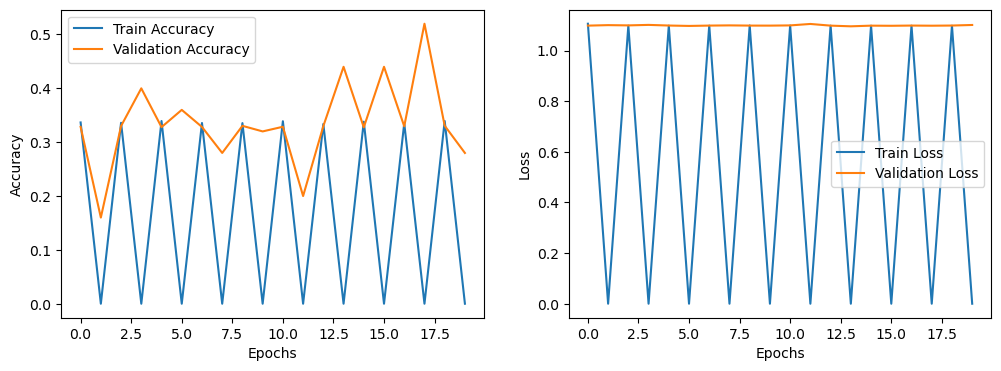

In [66]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_generator, steps=len(X_val) // 32)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [68]:
# Function to predict land cover class for a given image patch
def predict_land_cover(model, image_patch):
    image_patch = np.expand_dims(image_patch, axis=0)  # Add batch dimension
    prediction = model.predict(image_patch)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Example prediction
example_patch = image_patches[1]
predicted_class = predict_land_cover(model, example_patch)
print(f'Predicted Land Cover Class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Predicted Land Cover Class: 0
